# W207 Final Project - Facial Keypoint Recognition 
#### Alex Carite | Oscar Linares | Greg Rosen | Shehzad Shahbuddin

newcell-Shehzad
## Summary
The goal of this project is to identify 15 facial keypoints. Each facial keypoint consists of an x and y coordinate that aligns to the center (2), left and right corner (4) of each eye, left and right corner (4) of each eyebrow, tip of the nose (1), corners (2) and top and bottom center (2) of the mouth. 

Recognizing facial keypoints is necessary for biometrics/facial recognition, facial tracking in video, and facial expression analysis to name a few. 

Our approach in this project begins with data exploration and a baseline model. From there, we take measures to augment our data and look to leverage transfer learning in order to optimize our model's accuracy.


In [1]:
# dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

import time
import os.path
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import cv2
from random import randrange
from math import sin, cos, pi
%matplotlib inline

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, RandomFlip, RandomRotation
from tensorflow.keras import optimizers, Input, Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB7, EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2


np.random.seed(0)
print ("OK")
import tensorflow as tf
print("Tensorflow version", tf.__version__)

OK
Tensorflow version 2.8.0


### Load Data 

In [2]:
#Checking to see if the train/test csv are loaded, if not, unzip from dir
if (os.path.exists('training.csv') == False):
    !unzip training.zip
else:
    print('training data already unzipped')

if (os.path.exists('test.csv') == False):
    !unzip test.zip
else:
    print('test data already unzipped')

training data already unzipped
test data already unzipped


In [3]:
# load data
train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [4]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


In [5]:
# transform all data
X = np.array([two_dim(train.Image[i]) for i in range(len(train))])

X = X / 255.0
Y = np.array([train.drop('Image', axis = 1).iloc[i] for i in range(len(train))])

shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
train_data, train_labels = X[:5000], Y[:5000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
dev_data, dev_labels = X[5000:], Y[5000:]
numFeatures = train_data[1].size
numTrainExamples = train_data.shape[0]
numMiniExamples = mini_train_data.shape[0]
numDevExamples = dev_data.shape[0]
print(f'Train examples {numTrainExamples}')
print(f'Train features {numFeatures}')
print(f'mini_Train examples {numMiniExamples}')
print(f'Dev examples {numDevExamples}')


Train examples 5000
Train features 9216
mini_Train examples 1000
Dev examples 2049


# EDA

### Shehzad ChangeCell
At first glance, it appears that we have have a rich dataset with 5000 training examples and 2049 development data examples to test our model against; however, many of the labels are missing for our training examples. 

In [6]:
# helper functions for data shapes
def two_dim(image):
    'takes in an image vector of 9,216 pixels and makes it into a 96x96 shape'
    return np.array(image.split(' '), dtype=int).reshape(96, 96)

def make_array(image):
    return np.array(image.split(' '), dtype=int)


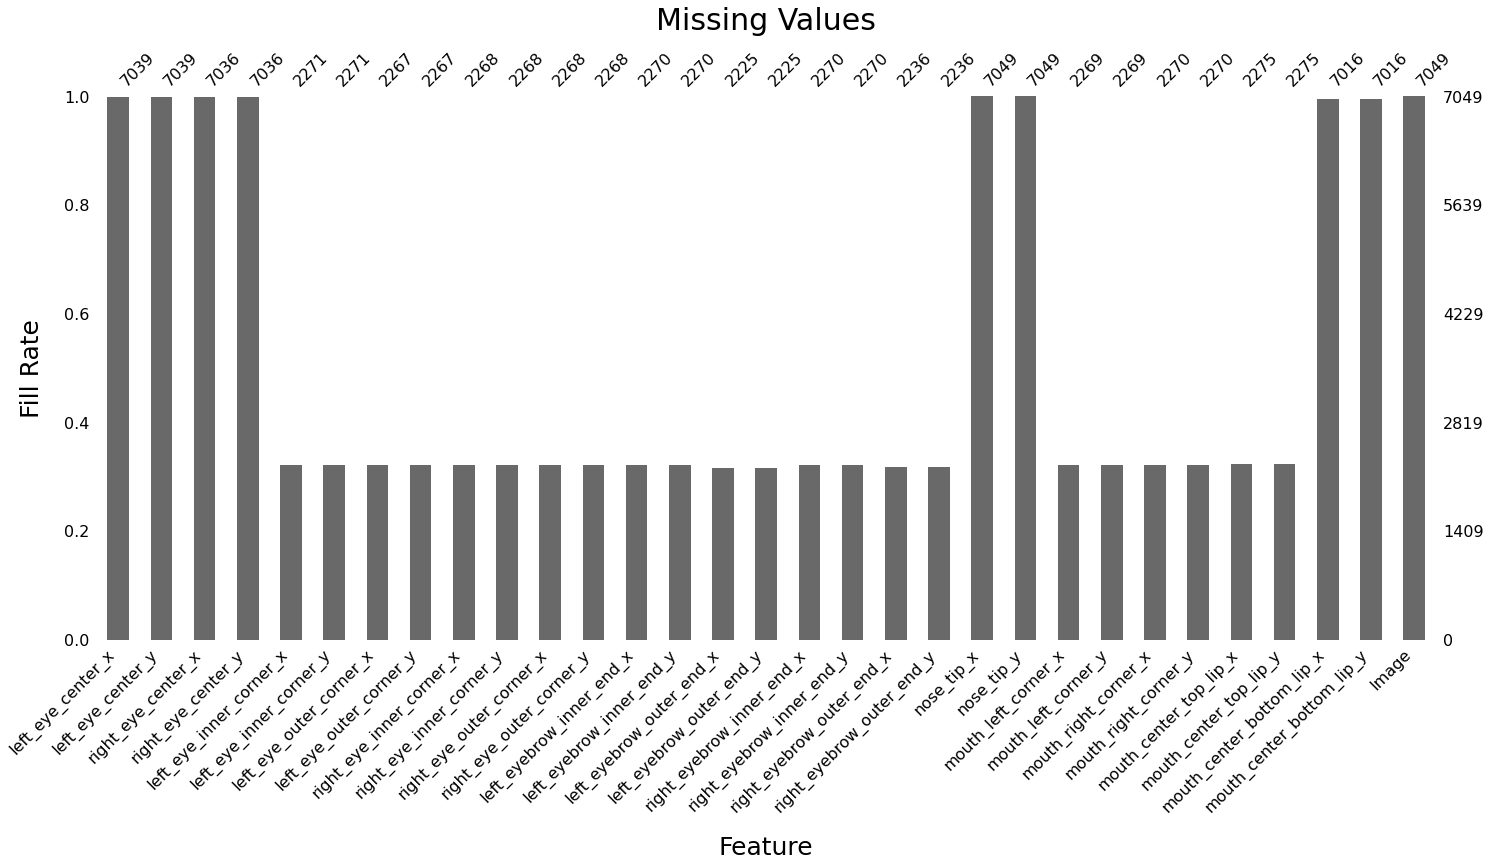

In [7]:
# view missing values
import missingno as msno
fig, ax = plt.subplots()
msno.bar(train)
ax.set_title("Missing Values", fontsize = 30, pad = 20)
ax.set_xlabel("Feature", fontsize = 25, labelpad = 20)
ax.set_ylabel("Fill Rate", fontsize = 25, labelpad = 20)
plt.show()

### Shehzad New_cell
The main challenge presented by our dataset is the abundance of NULL values. In particular, only a small number of our objective variables do not have missing values. Aside from a few key points (center of each eye, tip of the nose, and center of the mouth) a significant majority of the data is missing key labels. In fact, over 67% of the data are missing the necessary labels.

In [8]:
# EDA see percentage of na's for each column in the training dataset
train.isna().sum()/len(train)*100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

/Users/gregrosen/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


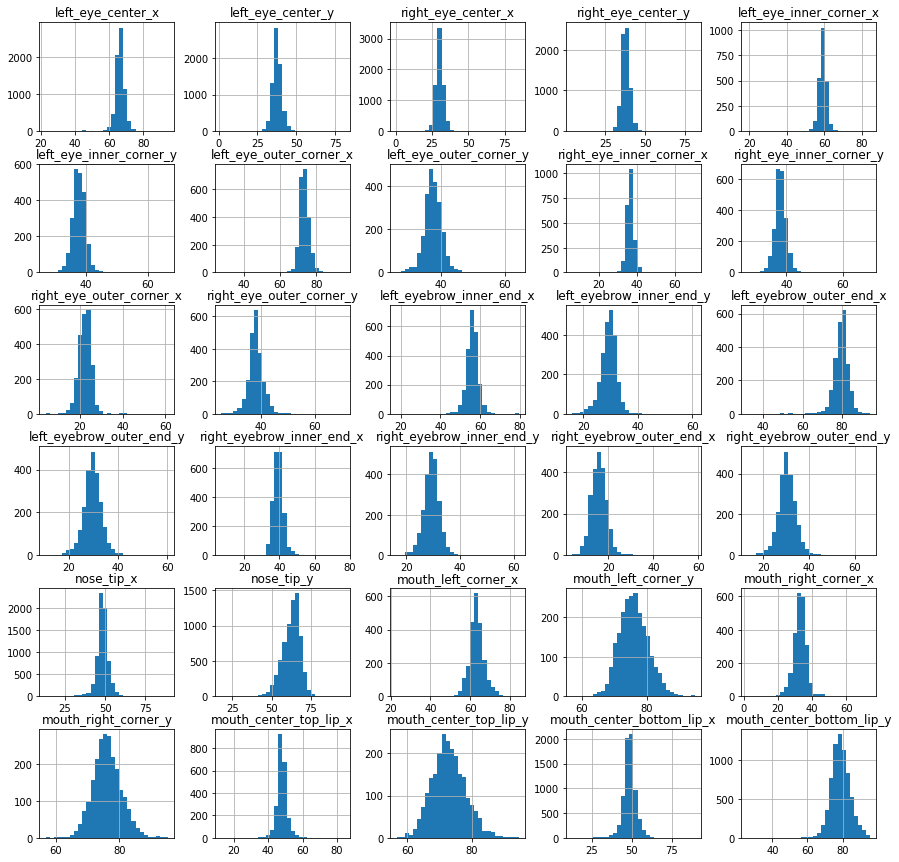

In [9]:
#continue EDA, see distribution of all coordinates in train data except the "Image" column
train.hist(bins = 30, figsize=(15,15))
plt.show()

### Shehzad Change_Cell

## Addressing Missing Values

The amount of NULL values will make prediction impossible. We choose to address the missing data issue with the following strategies:

- We will drop all missing values (we lose 70% of the dataset when removing NAs)
- We will also create a dataset with imputing the labels with forward fill. This will provide us with more available training data, but the imputed values will likely provide less accurate labels, which may harm our modeling moving forward. 

In [10]:
#drop NAs from train and split into training and dev
train_noNA_temp = train.dropna()
dev_set = train_noNA_temp[:500]
train_noNA = train_noNA_temp[500:]

#From the complete train set, drop the rows which will be included in the dev set
cond = train['Image'].isin(dev_set['Image'])
train.drop(train[cond].index, inplace = True)

#Create a ffill set based off the training data 
train_ffill = train.fillna(method='ffill')

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_labels(label_data):
    label_data = label_data.drop(['Image'], axis=1)
    label_features = []
    for idx, features in label_data.iterrows():
        label_features.append(features)
    label_features = np.array(label_features, dtype=float)
    return label_features


#Set of full data with ffill for missing labels
train_data_ffill  = load_images(train_ffill)
train_labels_ffill = load_labels(train_ffill)


#Dataset with only no NA rows
train_data_noNA  = load_images(train_noNA)
train_labels_noNA = load_labels(train_noNA)


#Dev set for testing 
dev_data = load_images(dev_set)
dev_labels = load_labels(dev_set)


#Test images for Kaggle competition 
test_images = load_images(test)


In [11]:
#Confirm size of the datasets
# OSCAR CHANGE
print('Number of records:', train_data.shape[0])
print('Number of records with no NULLS:', train_data_noNA.shape[0])

Number of records: 5000
Number of records with no NULLS: 1640


## Viusalizing the Images and Facial Keypoints

### Shehzad New_Cell

In order to determine the best path forward, we will visualize the available data to see how the examples with missing values appear, those with all labels available, as well as the forward filled imputed examples.

In [12]:
# OSCAR CHANGE
#Create function for showing images
def show_images(data, labels, num_examples=3, random=False):

    #transform data  into 2D matrix
    X2D = np.reshape(data, (-1, 96, 96))

    num = num_examples * 3
    count = 0

    #create a figure
    fig, axes = plt.subplots(num_examples, 3, figsize = (9.6, 9.6))
    
    if random:
        #iterate across the row of images and display one image in each of the num_examples boxes
        for n in range(num):
            ax = axes[count//num_examples, count%num_examples]
            rand = randrange(0, len(data))
            ax.imshow(X2D[rand], cmap = 'gray')
            count += 1
            for loc in range(0, len(labels[n]), 2):
                ax.plot(labels[rand][loc], labels[rand][loc+1], '*r')
    
    else:
        #iterate across the row of images and display one image in each of the num_examples boxes
        for n in range(num):
          ax = axes[count//num_examples, count%num_examples]
          ax.imshow(X2D[n], cmap = 'gray')
          count += 1
          for loc in range(0, len(labels[n]), 2):
              ax.plot(labels[n][loc], labels[n][loc+1], '*r')

    plt.tight_layout()
    plt.show()

### Example Images without all labeled points.

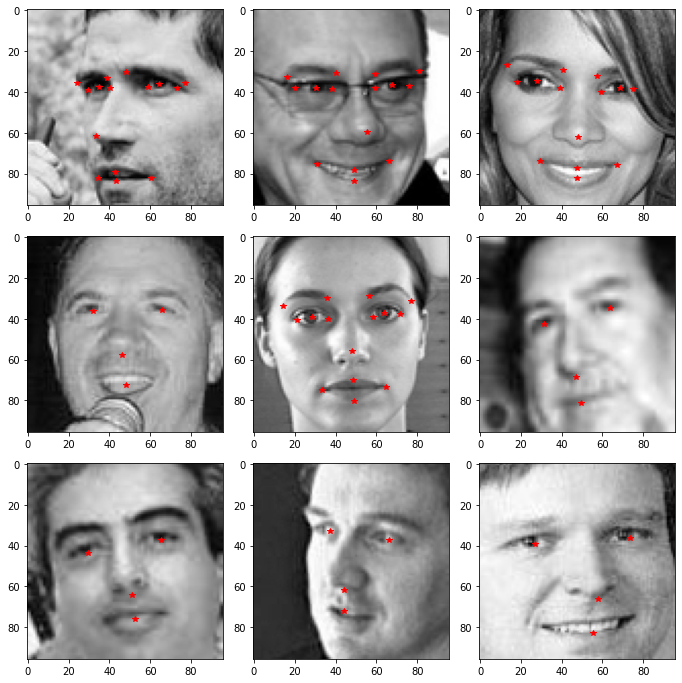

In [13]:
#explore some of the images in the training data
# OSCAR CHANGE
show_images(train_data, train_labels, random=True)

### Shehzad New_Cell

Aside from not having all the labels available, the examples with incomplete labels also appear to have partially mislabeled keypoints. Take the example above with row 2, images 1 and 3 with the center of the nose appearing below the correct tip of the nose. It is also difficult to determine if the label for the mouth is intended to be the top of the lip or the bottom as those same examples appear to just have the center of the lips labeled. 

### View images with all labels.

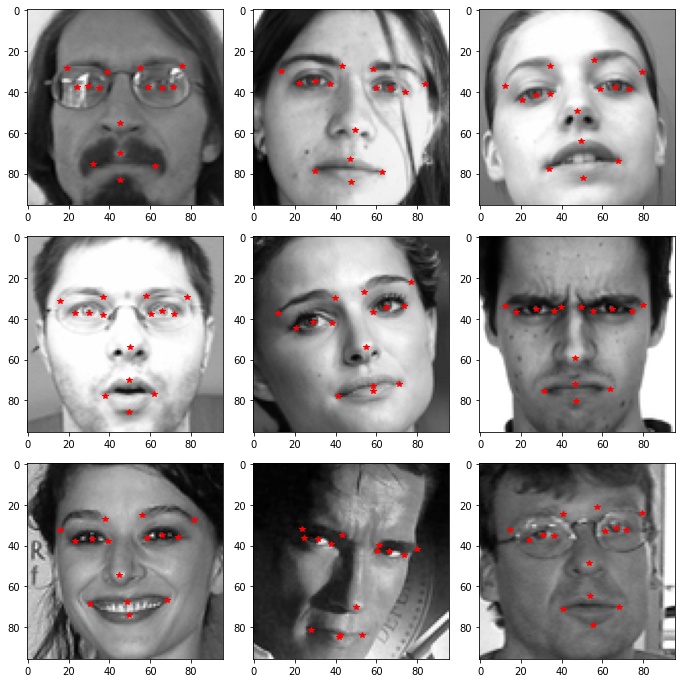

In [14]:
#Same analysis as above but with the noNA dataset - notice the how all the features are marked on the face
show_images(train_data_noNA, train_labels_noNA, random=True)

### Shehzad New_Cell

The examples for the fully labeled data appear to not only have the benefit of being complete, they also seem to have each of the labeled keypoints accurately positioned. Before we attempt to impute missing values for the incomplete labeled data, we believe that the no-Null dataset is the richest and will provide the most value to our future models. 

### View images with forward filled points.

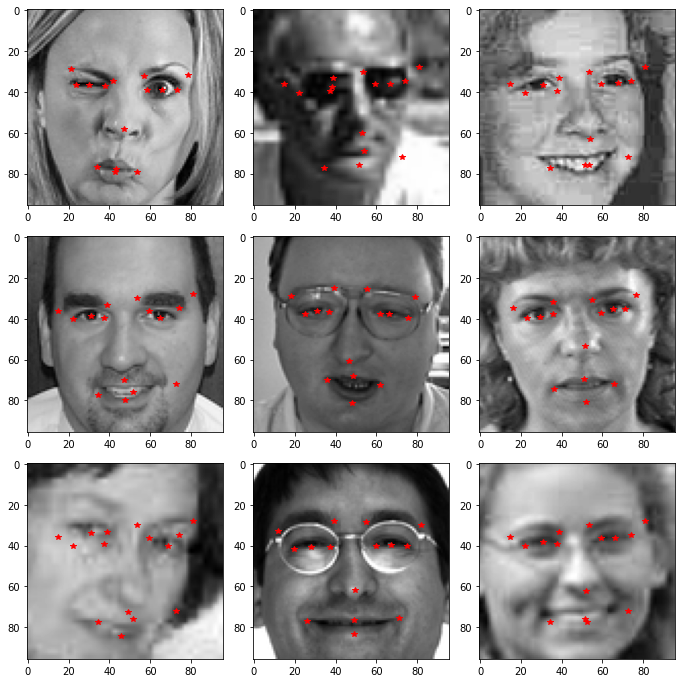

In [15]:
show_images(train_data_ffill, train_labels_ffill, random=True)

- while many of the ffill labels are close to the correct location, there is still a bit of discrepancy.

In [16]:
#take a look at removing outliers
# train_outliers  = train[((train['left_eye_inner_corner_x'] - train['left_eye_inner_corner_x'].mean()) / train['left_eye_inner_corner_x'].std()).abs() < 3]
# train_outliers = train[train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
# train_outliers.hist(bins = 30, figsize=(15,15))
# plt.show()

#create df for noNA data to do the same analysis as above
# tempdf = pd.DataFrame(train_labels_noNA)
# tempdf.hist(bins = 30, figsize=(15,15))
# plt.show()

In [17]:
#Confirm size of the datasets
print(train_data_noNA.shape)
print(train_labels_noNA.shape)
print(train_data_ffill.shape)
print(train_labels_ffill.shape)
print(dev_data.shape)
print(dev_labels.shape)

(1640, 96, 96, 1)
(1640, 30)
(6549, 96, 96, 1)
(6549, 30)
(500, 96, 96, 1)
(500, 30)


### Shehzad New_Cell

Since we only have 1640 training examples without any missing values, we want to increase our training dataset size so we will augment our existing examples using transformations such as rotation, altering the brightness, shifting the images, adding noise, or blurring the images.

## Augmenting the Data

In [18]:
# define image augmentation functions
def rotate_augmentation(images, keypoints, angles):
    rotated_images = []
    rotated_keypoints = []
    for angle in angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            rotation_matrix = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # rotate images
            for image in images:
                rotated_image = cv2.warpAffine(image, rotation_matrix, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            rotated_images_reshaped = np.reshape(rotated_images, (-1,96,96,1))
            # rotate keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            rotated_keypoints_reshaped = np.reshape(rotated_keypoints, (-1, 30))
    return rotated_images_reshaped, rotated_keypoints_reshaped

def alter_brightness(images, keypoints, increase_factor=1.2, decrease_factor=0.6):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*increase_factor, 0.0, 1.0)    # Increased brightness & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*decrease_factor, 0.0, 1.0)    # Decreased brightness & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    altered_brightness_images_reshaped = np.reshape(altered_brightness_images, (-1,96,96,1))
    altered_brightness_keypoints_reshaped = np.reshape(np.concatenate((keypoints, keypoints)), (-1, 30))
    return altered_brightness_images_reshaped, altered_brightness_keypoints_reshaped

def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            shift_matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, shift_matrix, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_images_reshaped = np.reshape(shifted_images, (-1,96,96,1))
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    shifted_keypoints_reshaped = np.reshape(shifted_keypoints, (-1, 30))
    return shifted_images_reshaped, shifted_keypoints_reshaped

def add_random_noise(images, keypoints, noise_factor=0.008):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, noise_factor*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    noisy_images_reshaped = np.reshape(noisy_images, (-1,96,96,1))
    return noisy_images_reshaped, keypoints

def guassian_blur(images, keypoints, kernel=(5,5)):
    blurred_images = []
    for image in images:
        dst = cv2.GaussianBlur(image, kernel, cv2.BORDER_DEFAULT)
        blurred_image = dst.reshape(96,96,1)
        blurred_images.append(blurred_image)
    blurred_images_reshaped = np.reshape(blurred_images, (-1,96,96,1))
    return blurred_images_reshaped, keypoints

In [19]:
# rotate images and keypoints
train_data_rotated, train_labels_rotated = rotate_augmentation(train_data_noNA, train_labels_noNA, [12])

# alter brightness
train_data_brightness, train_labels_brightness = alter_brightness(
                                                        train_data_noNA,
                                                        train_labels_noNA,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_shifted, train_labels_shifted = shift_images(train_data_noNA, train_labels_noNA, [12])

# add random noise
train_data_noise, train_labels_noise = add_random_noise(train_data_noNA, train_labels_noNA, 0.03)

# apply gaussian blur
train_data_blurred, train_labels_blurred = guassian_blur(train_data_noNA, train_labels_noNA, kernel=(5,5))

In [20]:
# merge all augmented data
train_data_aug = np.concatenate(
    (train_data_noNA, train_data_rotated, train_data_shifted, train_data_brightness, train_data_noise, train_data_blurred)
)

train_labels_aug = np.concatenate(
    (train_labels_noNA, train_labels_rotated, train_labels_shifted, train_labels_brightness, train_labels_noise, train_labels_blurred)
)

print(train_data_aug.shape)
print(train_labels_aug.shape)

(16267, 96, 96, 1)
(16267, 30)


Our training dataset increased by about 10x after adding the augmented data.

### Doing Same Augmentation on FFill label Data

In [21]:
# OSCAR CHANGE
# rotate images and keypoints
train_data_ffill_rotated, train_labels_ffill_rotated = rotate_augmentation(train_data_ffill, train_labels_ffill, [12])

# alter brightness
train_data_ffill_brightness, train_labels_ffill_brightness = alter_brightness(
                                                        train_data_ffill,
                                                        train_labels_ffill,
                                                        increase_factor=1.2,
                                                        decrease_factor=0.6
                                                    )

# shift images and keypoints
train_data_ffill_shifted, train_labels_ffill_shifted = shift_images(train_data_ffill, train_labels_ffill, [12])

# add random noise
train_data_ffill_noise, train_labels_ffill_noise = add_random_noise(train_data_ffill, train_labels_ffill, 0.03)

# apply gaussian blur
train_data_ffill_blurred, train_labels_ffill_blurred = guassian_blur(train_data_ffill, train_labels_ffill, kernel=(5,5))

# merge all augmented data
train_data_ffill_aug = np.concatenate(
    (train_data_ffill, train_data_ffill_rotated, train_data_ffill_shifted, train_data_ffill_brightness, train_data_ffill_noise, train_data_ffill_blurred)
)

train_labels_ffill_aug = np.concatenate(
    (train_labels_ffill, train_labels_ffill_rotated, train_labels_ffill_shifted, train_labels_ffill_brightness, train_labels_ffill_noise, train_labels_ffill_blurred)
)

In [22]:
# merge all augmented data
train_data_ffill_aug = np.concatenate(
    (train_data_ffill, train_data_ffill_rotated, train_data_ffill_shifted, train_data_ffill_brightness, train_data_ffill_noise, train_data_ffill_blurred)
)

train_labels_ffill_aug = np.concatenate(
    (train_labels_ffill, train_labels_ffill_rotated, train_labels_ffill_shifted, train_labels_ffill_brightness, train_labels_ffill_noise, train_labels_ffill_blurred)
)

print(train_data_ffill_aug.shape)
print(train_labels_ffill_aug.shape)

(69362, 96, 96, 1)
(69362, 30)


# Modeling on the data

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',
                             baseline=None)

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

In [30]:
### GREG CHANGE
# shape tuples for reshaping the data for model
train_reshape = (5000, 9216)
train_noNA_reshape = (1640, 9216)
dev_reshape = (2049, 9216)
dev_noNA_reshape = (500, 9216)
label_reshape= (-1, 30)
dev_data_baseline_reshape = (588, 9216)

In [31]:
#function to pickle the models
def pickle_stuff(model, time, history, model_type, folder = 'models/'):
    model_name = folder + model_type
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        pickle.dump(time, f)
        pickle.dump(history, f)

#function to unpickle the models
def unpickle_stuff(model_type, folder = 'models/'):
    with open(folder + model_type, 'rb') as f:
        model = pickle.load(f)
        time = pickle.load(f)
        history = pickle.load(f)
    return model, time, history

### Baseline
- creating a perceptron model with a single hidden layer

In [32]:
### GREG ADD
dev_data_baseline, dev_labels_baseline = X[5000:], Y[5000:]
label_index = pd.DataFrame(dev_labels_baseline).dropna().index
dev_labels_baseline = pd.DataFrame(dev_labels_baseline).dropna()
dev_data_baseline = dev_data_baseline[label_index,:]

In [34]:
### GREG CHANGE
# baseline model
model_base = Sequential()
model_base.add(Dense(units=30, input_dim = 9216, activation='sigmoid'))
model_base.add(Dense(units=30, input_dim = 30, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model_base.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

start_time_base = time.time()
history = model_base.fit(train_data.reshape(train_reshape), train_labels, shuffle=True, batch_size=1, verbose=0, epochs=20)
train_time_base = time.time() - start_time_base
print ('Train time = ', train_time_base)
score_base = model_base.evaluate(dev_data_baseline.reshape(dev_data_baseline_reshape), dev_labels_baseline, verbose=0) 
print('Test score:', score_base[0]) 
print('Test accuracy:', score_base[1])

Train time =  72.12571477890015
Test score: nan
Test accuracy: 0.0


### Missing Value Records Removed

In [35]:
### GREG CHANGE
# No NA model
model_NN_noNA1 = Sequential()
# model_NN_noNA1.add(Dense(30, input_dim=9216, activation='sigmoid'))
# model_NN_noNA1.add(Dense(30, input_dim=30, activation='sigmoid'))
model_NN_noNA1.add(Dense(units=30, input_dim=9216, activation='softmax'))

sgd = optimizers.SGD(learning_rate=0.01)
model_NN_noNA1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
start_time_noNA1 = time.time()
history = model_NN_noNA1.fit(train_data_noNA.reshape(train_noNA_reshape), train_labels_noNA, shuffle=False, batch_size=1, verbose=0, epochs=10) 
train_time_noNA1 = time.time() - start_time_noNA1
score_NN_noNA1 = model_NN_noNA1.evaluate(dev_data.reshape(dev_noNA_reshape), dev_labels, verbose=0) 
print('Test score:', score_NN_noNA1[0]) 
print('Test accuracy:', score_NN_noNA1[1])

Test score: 12976113664.0
Test accuracy: 0.8299999833106995


Because baseline performance is higher on the missing-value-removed model, and the filled values on the missing-value records are inaccurate, we will proceed with iterating on the no-na model (or maybe we will add an additional label that specifies which records had imputed values) so the model can take that into consideration.

### Convolutional Model Baseline Attempt (FFILL)

In [27]:
#build archetecture
model_CNN_ffill1 = Sequential() 
model_CNN_ffill1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_ffill1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_ffill1.add(Dropout(0.5))
model_CNN_ffill1.add(Flatten())
model_CNN_ffill1.add(Dense(96))
model_CNN_ffill1.add(BatchNormalization())
model_CNN_ffill1.add(Activation('relu'))
model_CNN_ffill1.add(Dense(30))

model_CNN_ffill1.summary()
model_CNN_ffill1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#Train the model
start_time_CNN_ffill1 = time.time()
history_CNN_ffill1 = model_CNN_ffill1.fit(train_data_ffill, train_labels_ffill, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_CNN_ffill1 = time.time() - start_time_CNN_ffill1


#pickle 
pickle_stuff(model_CNN_ffill1, train_time_CNN_ffill1, history_CNN_ffill1, 'CNN_ffill1')

##unpickle
# model_CNN_ffill1, train_time_CNN_ffill1, history_CNN_ffill1 = unpickle_stuff('CNN_ffill1')


#Score the model
score_CNN_ffill1 = model_CNN_ffill1.evaluate(dev_data, dev_labels, verbose=0)
print('Test score:', score_CNN_ffill1[0]) 
print('Test accuracy:', score_CNN_ffill1[1])



Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 64)        0         
                                                                 
 flatten (Flatten)           (None, 141376)            0         
                                                                 
 dense (Dense)               (None, 96)                13572192  
                                                                 
 batch_normalization (BatchN  (None, 96)

Text(0.5, 0.98, 'Model Metrics')

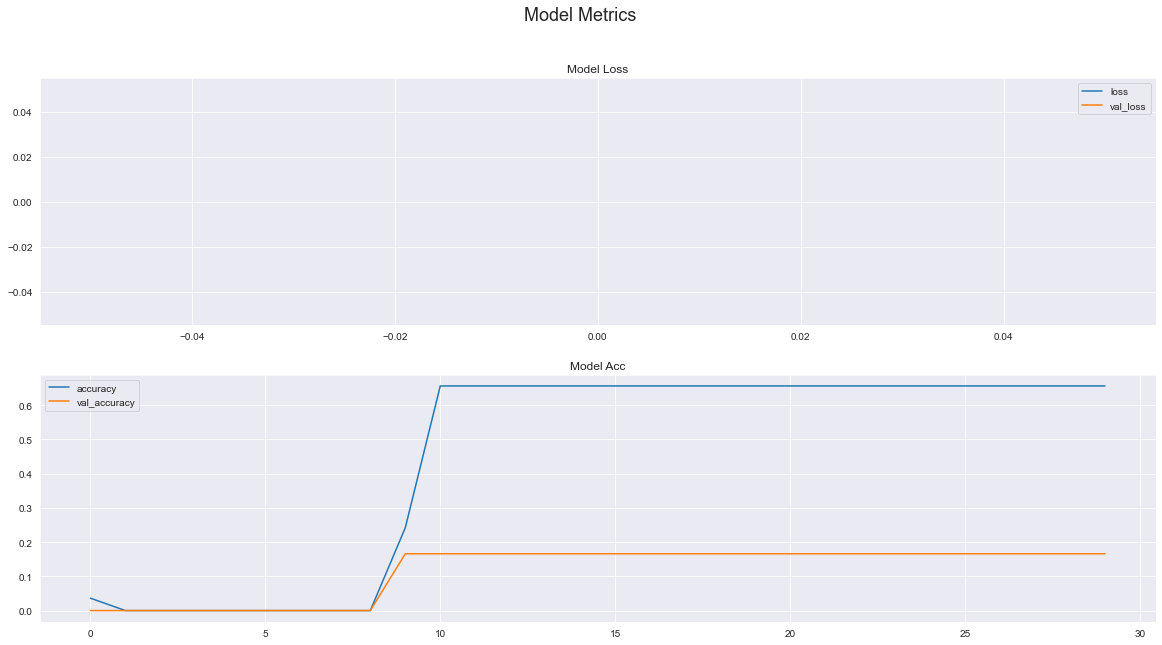

In [28]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_ffill1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Same CNN as before, but training with the noNA dataset

In [29]:
#Build Model Architecture
model_CNN_noNA1 = Sequential() 
model_CNN_noNA1.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=(96, 96, 1)))
model_CNN_noNA1.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN_noNA1.add(Dropout(0.2))
model_CNN_noNA1.add(Flatten())
model_CNN_noNA1.add(Dense(96))
model_CNN_noNA1.add(BatchNormalization())
model_CNN_noNA1.add(Activation('relu'))
model_CNN_noNA1.add(Dense(30))

model_CNN_noNA1.summary()
model_CNN_noNA1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


#Train Model
start_time_CNN_noNA1 = time.time()
history_CNN_noNA1 = model_CNN_noNA1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_CNN_noNA1 = time.time() - start_time_CNN_noNA1

#Pickle
pickle_stuff(model_CNN_noNA1, train_time_CNN_noNA1, history_CNN_noNA1, 'model_CNN_noNA1')

# #unpickle
# model_CNN_noNA1, train_time_CNN_noNA1, history_CNN_noNA1 = unpickle_stuff('model_CNN_noNA1')


#evaluate the model
score_CNN_noNA1 = model_CNN_noNA1.evaluate(dev_data, dev_labels)
print('Test score:', score_CNN_noNA1[0]) 
print('Test accuracy:', score_CNN_noNA1[1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 47, 47, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 141376)            0         
                                                                 
 dense_2 (Dense)             (None, 96)                13572192  
                                                                 
 batch_normalization_1 (Batc  (None, 96)               384       
 hNormalization)                                      

Text(0.5, 0.98, 'Model Metrics')

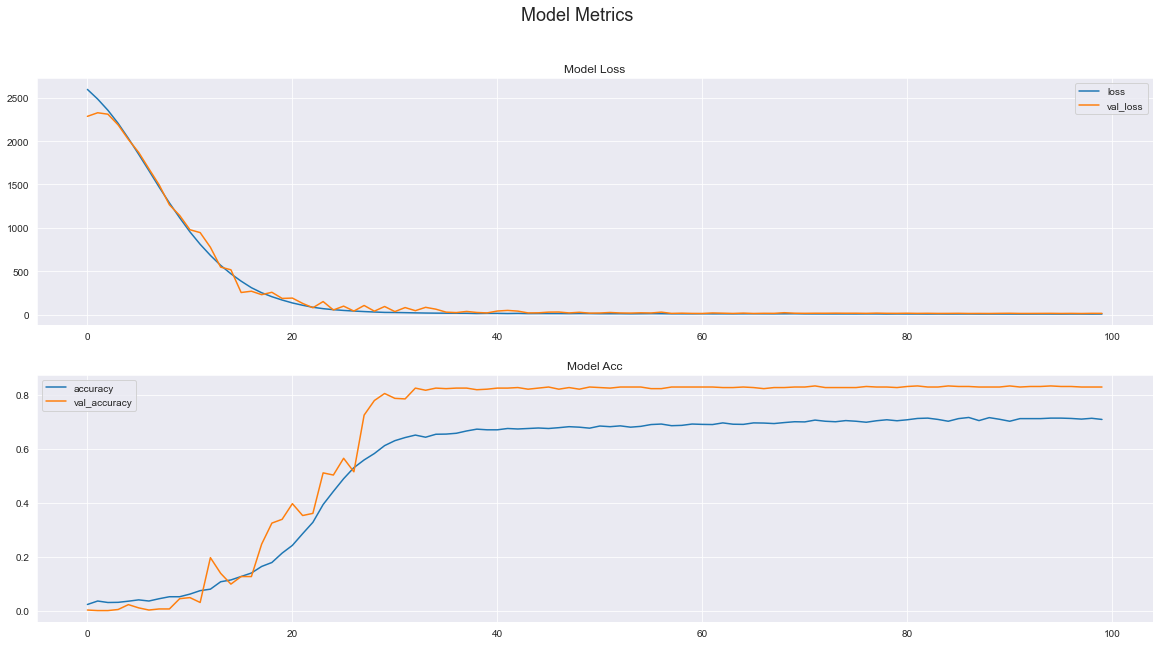

In [30]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_CNN_noNA1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Transfer learning with Resnet50: CNN with Pre-trained Resnet and one dense layer

In [31]:
model_resnet_noNA_D1 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

#Build Model
model_resnet_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D1.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D1.add(pretrained_model)
model_resnet_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D1.add(Dropout(0.1))
model_resnet_noNA_D1.add(Flatten())
model_resnet_noNA_D1.add(Dense(30))
model_resnet_noNA_D1.summary()

model_resnet_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                      

In [32]:
#Train Model 
start_time_resnet_noNA_D1 = time.time()
history_resnet_noNA_D1 = model_resnet_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_D1 = time.time() - start_time_resnet_noNA_D1

#pickle
pickle_stuff(model_resnet_noNA_D1, train_time_resnet_noNA_D1, history_resnet_noNA_D1, 'model_resnet_noNA_D1')

# #unpickle
# model_resnet_noNA_D1, train_time_resnet_noNA_D1, history_resnet_noNA_D1 = unpickle_stuff('model_resnet_noNA_D1')

score_resnet_noNA_D1 = model_resnet_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D1[0]) 
print('Test accuracy:', score_resnet_noNA_D1[1])


Epoch 1/100
26/26 [==============================] - 11s 292ms/step - loss: 344.1587 - accuracy: 0.4707 - val_loss: 336.4366 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 6s 248ms/step - loss: 16.2841 - accuracy: 0.5982 - val_loss: 248.5197 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 6s 247ms/step - loss: 15.3423 - accuracy: 0.5915 - val_loss: 35.1170 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 254ms/step - loss: 14.8818 - accuracy: 0.6061 - val_loss: 90.5400 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 6s 247ms/step - loss: 14.7133 - accuracy: 0.6104 - val_loss: 87.1902 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 6s 249ms/step - loss: 14.1969 - accuracy: 0.6146 - val_loss: 50.6176 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 7/100
26/26 [=================

Text(0.5, 0.98, 'Model Metrics')

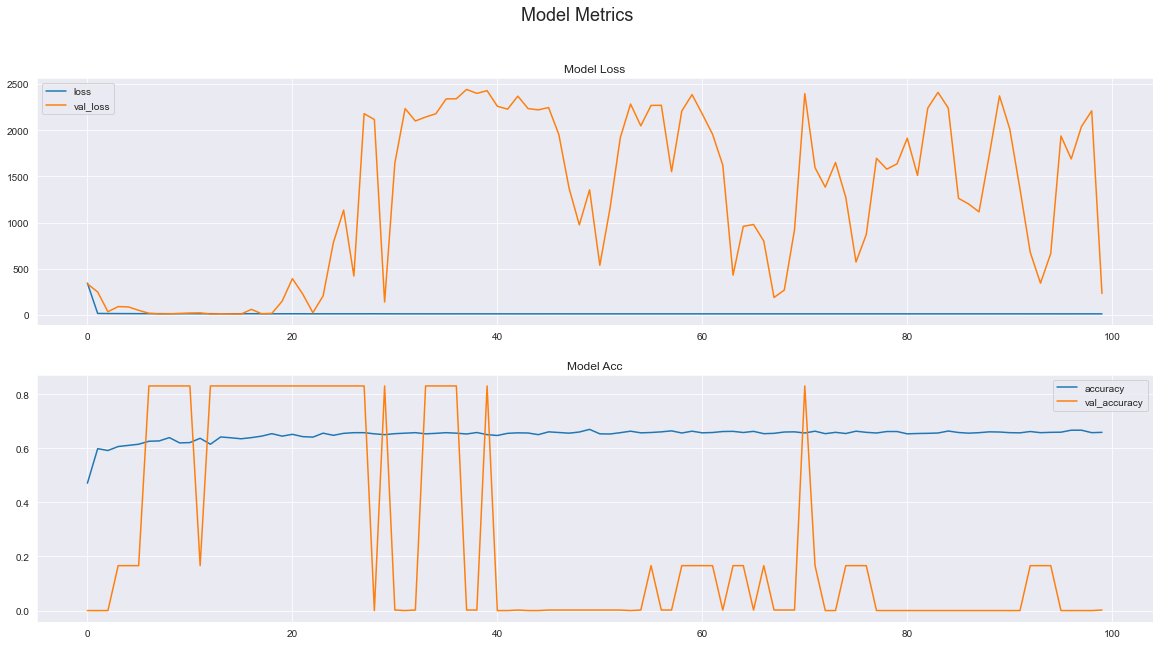

In [33]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet pretrained with two dense layers

In [34]:
#Build resnet model
model_resnet_noNA_D2 = Sequential() 
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_resnet_noNA_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_D2.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_D2.add(pretrained_model)
model_resnet_noNA_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_D2.add(Dropout(0.1))
model_resnet_noNA_D2.add(Flatten())
model_resnet_noNA_D2.add(Dense(96))
model_resnet_noNA_D2.add(Dense(30))

model_resnet_noNA_D2.summary()

model_resnet_noNA_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                      

In [35]:
#Train Model
start_time_resnet_noNA_D2 = time.time()
history_resnet_noNA_D2 = model_resnet_noNA_D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_D2 = time.time() - start_time_resnet_noNA_D2

#pickle
pickle_stuff(model_resnet_noNA_D2, train_time_resnet_noNA_D2, history_resnet_noNA_D2, 'model_resnet_noNA_D2')

# #unpickle
# model_resnet_noNA_D2, train_time_resnet_noNA_D2, history_resnet_noNA_D2 = unpickle_stuff('model_resnet_noNA_D2')

#Evaluate Model
score_resnet_noNA_D2 = model_resnet_noNA_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_D2[0]) 
print('Test accuracy:', score_resnet_noNA_D2[1])

Epoch 1/100
26/26 [==============================] - 12s 312ms/step - loss: 273.3373 - accuracy: 0.4793 - val_loss: 427.4382 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 255ms/step - loss: 13.4316 - accuracy: 0.6238 - val_loss: 959.9689 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 6s 248ms/step - loss: 7.4700 - accuracy: 0.6622 - val_loss: 436.0302 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 6s 247ms/step - loss: 7.7443 - accuracy: 0.6982 - val_loss: 160.8788 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 6s 247ms/step - loss: 5.9828 - accuracy: 0.6854 - val_loss: 118.1626 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 6s 247ms/step - loss: 4.7455 - accuracy: 0.7024 - val_loss: 101.5212 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [=========================

Text(0.5, 0.98, 'Model Metrics')

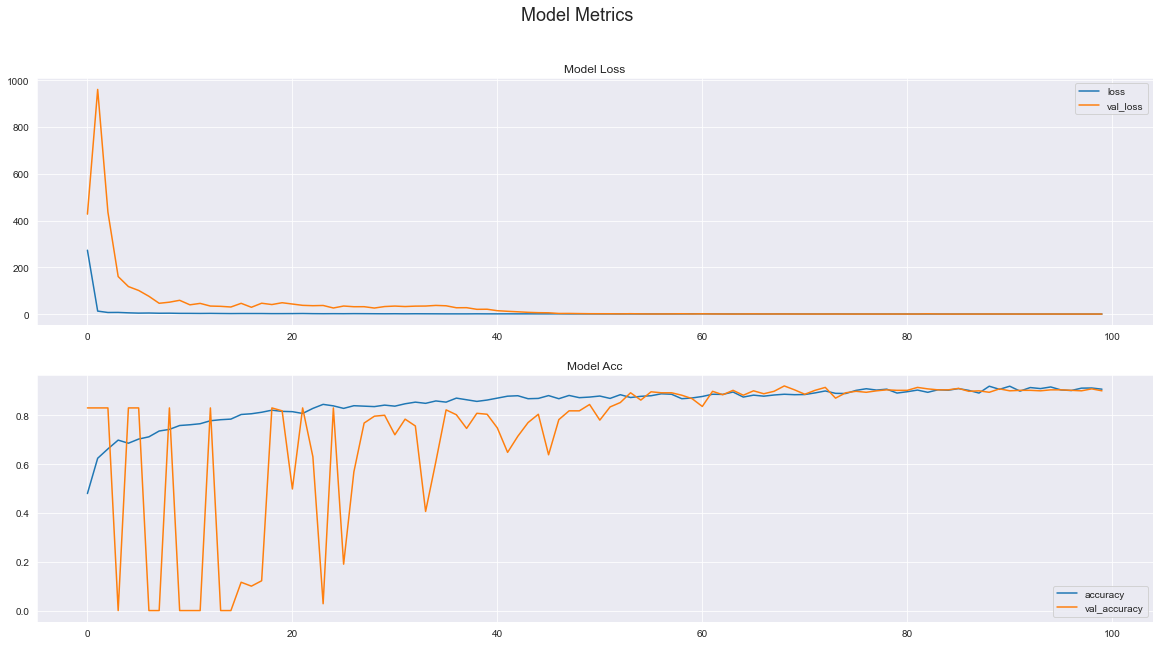

In [36]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### ResnetV2 With lots of Dense Layers


In [37]:
#Build resnet model
model_resnet_noNA_C1D4 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_resnet_noNA_C1D4.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.2))
model_resnet_noNA_C1D4.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 64)))
model_resnet_noNA_C1D4.add(LeakyReLU(alpha=0.1))
model_resnet_noNA_C1D4.add(pretrained_model)
model_resnet_noNA_C1D4.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_noNA_C1D4.add(Dropout(0.1))
model_resnet_noNA_C1D4.add(Flatten())
model_resnet_noNA_C1D4.add(Dense(1024))
model_resnet_noNA_C1D4.add(Dense(512))
model_resnet_noNA_C1D4.add(Dense(96))
model_resnet_noNA_C1D4.add(Dense(30))


model_resnet_noNA_C1D4.summary()

model_resnet_noNA_C1D4.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 96, 96, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 3)         195       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 2048)       0         
 2D)                                                             
                                                      

In [38]:
#Train Model
start_time_resnet_noNA_C1D4 = time.time()
history_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_noNA_C1D4 = time.time() - start_time_resnet_noNA_C1D4

#pickle
pickle_stuff(model_resnet_noNA_C1D4, train_time_resnet_noNA_C1D4, history_resnet_noNA_C1D4, 'model_resnet_noNA_C1D4')

# #unpickle
# model_resnet_noNA_C1D4, train_time_resnet_noNA_C1D4, history_resnet_noNA_C1D4 = unpickle_stuff('model_resnet_noNA_C1D4')

score_resnet_noNA_C1D4 = model_resnet_noNA_C1D4.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_noNA_C1D4[0]) 
print('Test accuracy:', score_resnet_noNA_C1D4[1])

Epoch 1/100
26/26 [==============================] - 13s 349ms/step - loss: 550.8181 - accuracy: 0.2780 - val_loss: 636.5093 - val_accuracy: 0.0400 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 7s 266ms/step - loss: 27.8861 - accuracy: 0.5848 - val_loss: 319.6352 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 7s 255ms/step - loss: 12.8736 - accuracy: 0.6311 - val_loss: 89.5739 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 7s 256ms/step - loss: 11.3921 - accuracy: 0.6451 - val_loss: 19.0023 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 7s 256ms/step - loss: 10.4870 - accuracy: 0.6622 - val_loss: 18.5030 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 7s 257ms/step - loss: 9.1467 - accuracy: 0.6591 - val_loss: 20.7484 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==============================

Text(0.5, 0.98, 'Model Metrics')

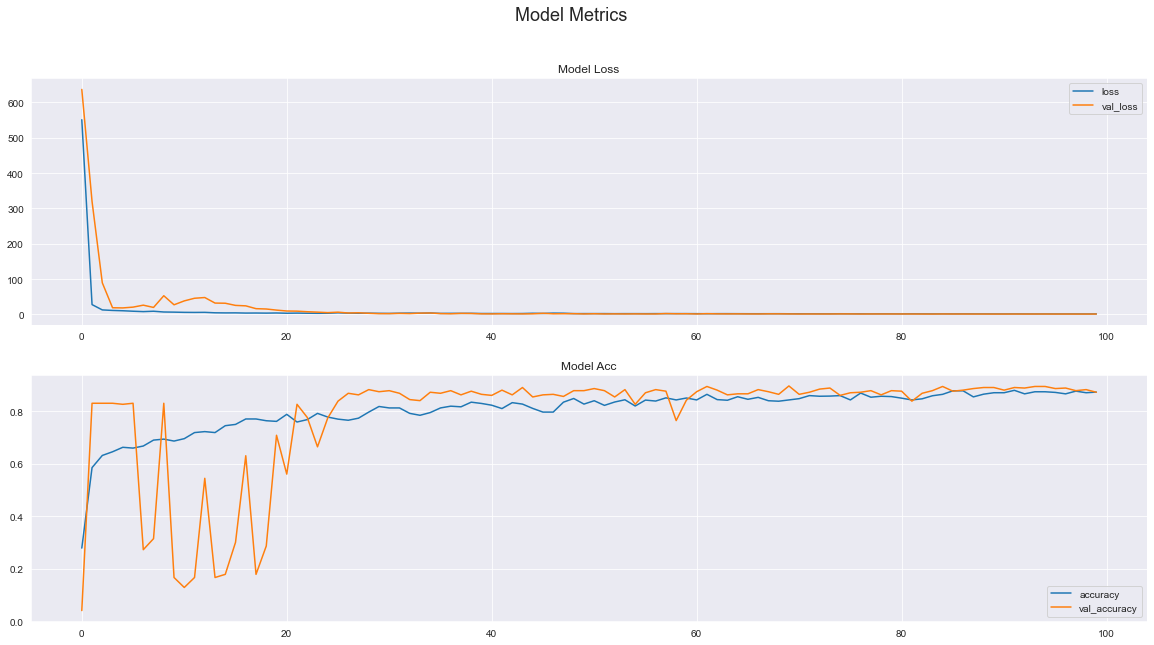

In [39]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_noNA_C1D4.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Efficient Net (1 Dense Layer)

In [40]:
#Build effnet model
model_effnetB7_noNA_D1 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_effnetB7_noNA_D1.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_noNA_D1.add(LeakyReLU(alpha=0.1))
model_effnetB7_noNA_D1.add(pretrained_model)
model_effnetB7_noNA_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_noNA_D1.add(Dropout(0.1))
model_effnetB7_noNA_D1.add(Flatten())
model_effnetB7_noNA_D1.add(Dense(30))


model_effnetB7_noNA_D1.summary()

model_effnetB7_noNA_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 2560)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 1, 1, 2560)        0         
                                                                 
 flatten_5 (Flatten)         (None, 2560)              0         
                                                      

In [41]:
#Train Model
start_time_effnetB7_noNA_D1 = time.time()
history_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetB7_noNA_D1 = time.time() - start_time_effnetB7_noNA_D1

#pickle
pickle_stuff(model_effnetB7_noNA_D1, train_time_effnetB7_noNA_D1, history_effnetB7_noNA_D1, 'model_effnetB7_noNA_D1')

# #unpickle
# model_effnetB7_noNA_D1, train_time_effnetB7_noNA_D1, history_effnetB7_noNA_D1 = unpickle_stuff('model_effnetB7_noNA_D1')

score_effnetB7_noNA_D1 = model_effnetB7_noNA_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_noNA_D1[0]) 
print('Test accuracy:', score_effnetB7_noNA_D1[1])

Epoch 1/100
26/26 [==============================] - 87s 2s/step - loss: 407.1906 - accuracy: 0.3829 - val_loss: 127.3067 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 32s 1s/step - loss: 20.9825 - accuracy: 0.6616 - val_loss: 155.9472 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 30s 1s/step - loss: 13.6541 - accuracy: 0.6610 - val_loss: 159.6392 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 30s 1s/step - loss: 12.7468 - accuracy: 0.6616 - val_loss: 91.4345 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 30s 1s/step - loss: 12.1671 - accuracy: 0.6604 - val_loss: 71.4709 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 30s 1s/step - loss: 10.7136 - accuracy: 0.6555 - val_loss: 77.3019 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 30s 1s/

Text(0.5, 0.98, 'Model Metrics')

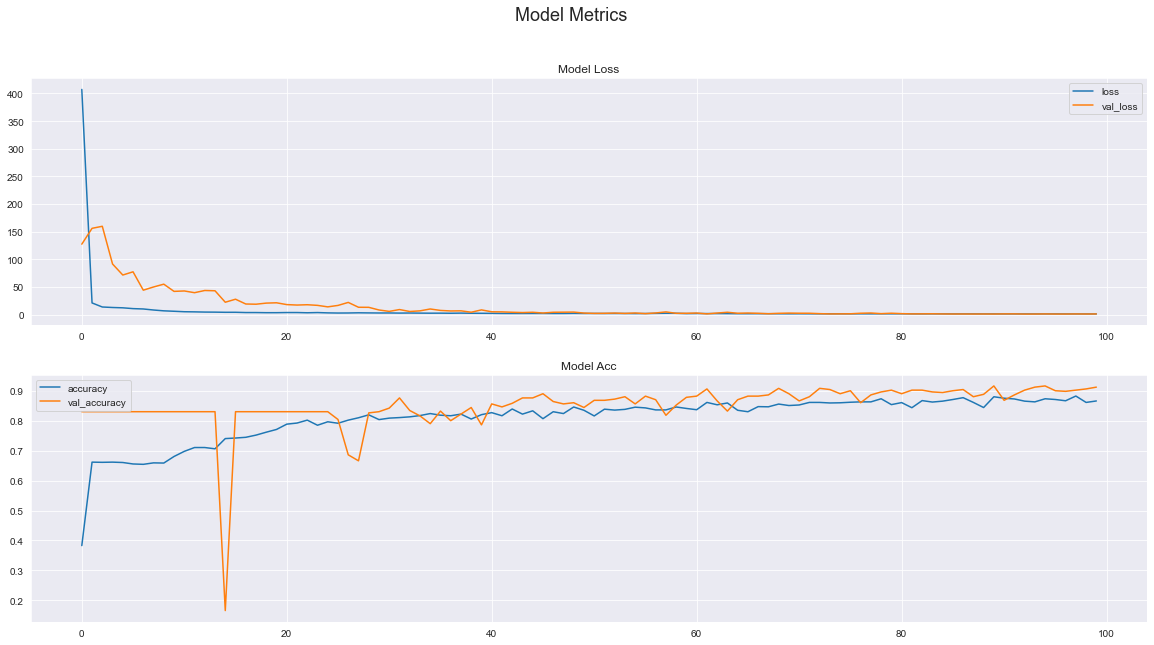

In [42]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_noNA_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### EfficientNet_v2B3 try number 2 (two conv, two dense, using Efficientnetv2_B3)


In [43]:
#Build effnet model
model_effnetV2B3_noNA_C2D2 = Sequential() 
pretrained_model = EfficientNetV2B3(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_effnetV2B3_noNA_C2D2.add(Conv2D(24, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.2))
model_effnetV2B3_noNA_C2D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same' ,input_shape=(96, 96, 24)))
model_effnetV2B3_noNA_C2D2.add(LeakyReLU(alpha=0.1))
model_effnetV2B3_noNA_C2D2.add(pretrained_model)
model_effnetV2B3_noNA_C2D2.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetV2B3_noNA_C2D2.add(Dropout(0.1))
model_effnetV2B3_noNA_C2D2.add(Flatten())
model_effnetV2B3_noNA_C2D2.add(Dense(90))
model_effnetV2B3_noNA_C2D2.add(Dense(30))


model_effnetV2B3_noNA_C2D2.summary()

model_effnetV2B3_noNA_C2D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 24)        120       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 96, 96, 24)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 3)         75        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetv2-b3 (Function  (None, 3, 3, 1536)       12930622  
 al)                                                             
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 1536)       0         
 2D)                                                  

In [44]:
#Train Model
start_time_effnetV2B3_noNA_C2D2 = time.time()
history_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.fit(train_data_noNA, train_labels_noNA, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetV2B3_noNA_C2D2 = time.time() - start_time_effnetV2B3_noNA_C2D2

#pickle
pickle_stuff(model_effnetV2B3_noNA_C2D2, train_time_effnetV2B3_noNA_C2D2, history_effnetV2B3_noNA_C2D2, 'model_effnetV2B3_noNA_C2D2')

# #unpickle
# model_effnetV2B3_noNA_C2D2, train_time_effnetV2B3_noNA_C2D2, history_effnetV2B3_noNA_C2D2 = unpickle_stuff('model_effnetV2B3_noNA_C2D2')

#Evaluate Model
score_effnetV2B3_noNA_C2D2 = model_effnetV2B3_noNA_C2D2.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetV2B3_noNA_C2D2[0]) 
print('Test accuracy:', score_effnetV2B3_noNA_C2D2[1])

Epoch 1/100
26/26 [==============================] - 45s 1s/step - loss: 378.5166 - accuracy: 0.3299 - val_loss: 12.7924 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 10s 395ms/step - loss: 14.2514 - accuracy: 0.6555 - val_loss: 646.5554 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 8s 327ms/step - loss: 11.9653 - accuracy: 0.6518 - val_loss: 74.5094 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 8s 317ms/step - loss: 11.7196 - accuracy: 0.6610 - val_loss: 7.5806 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 8s 298ms/step - loss: 11.7721 - accuracy: 0.6573 - val_loss: 9.9870 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 8s 300ms/step - loss: 11.3074 - accuracy: 0.6671 - val_loss: 70.6331 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 

Text(0.5, 0.98, 'Model Metrics')

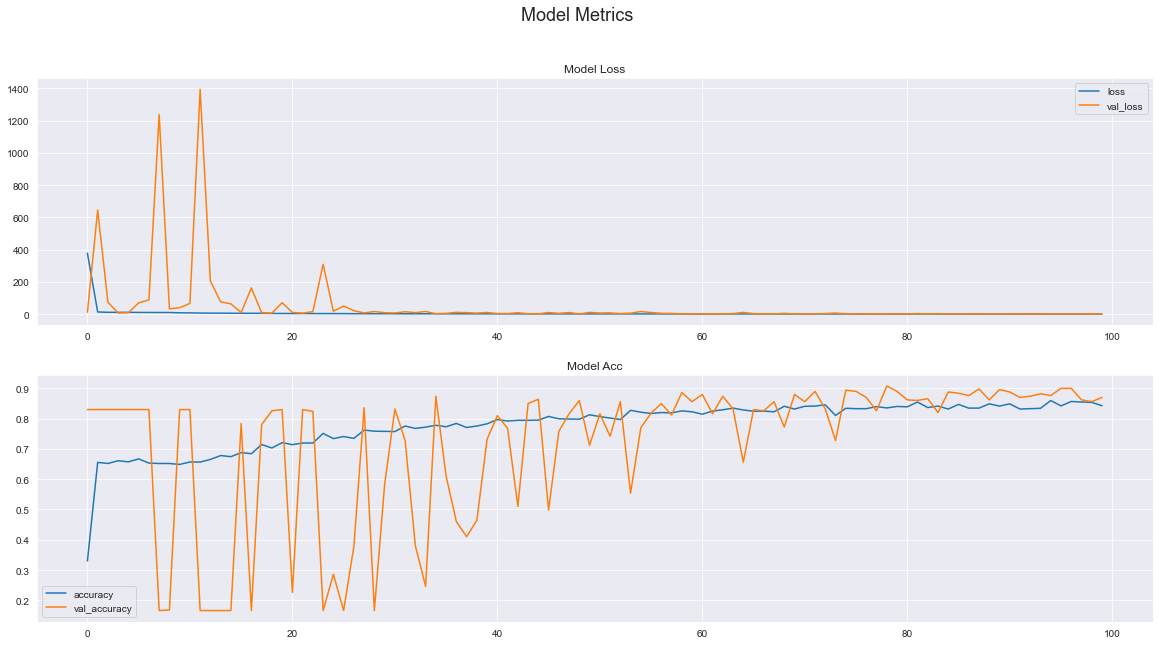

In [45]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetV2B3_noNA_C2D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Resnet50 with Augmented Data - Transfer Learning

In [46]:
#Build Resnet model
model_resnet_aug_D2 = Sequential() 
pretrained_model = ResNet50V2(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_resnet_aug_D2.add(Conv2D(3, kernel_size=(1, 1), activation='relu', padding= 'same',  input_shape=(96, 96, 1)))
model_resnet_aug_D2.add(LeakyReLU(alpha=0.1))
model_resnet_aug_D2.add(pretrained_model)
model_resnet_aug_D2.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet_aug_D2.add(Dropout(0.1))
model_resnet_aug_D2.add(Flatten())
model_resnet_aug_D2.add(Dense(96))
model_resnet_aug_D2.add(Dense(30))


model_resnet_aug_D2.summary()
model_resnet_aug_D2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 1, 1, 2048)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                      

In [47]:
#Train Model
start_time_resnet_aug_D2 = time.time()
history_resnet_aug_D2 = model_resnet_aug_D2.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=100, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_resnet_aug_D2 = time.time() - start_time_resnet_aug_D2

#pickle
pickle_stuff(model_resnet_aug_D2, train_time_resnet_aug_D2, history_resnet_aug_D2, 'model_resnet_aug_D2')

# #unpickle
# model_resnet_aug_D2, train_time_resnet_aug_D2, history_resnet_aug_D2 = unpickle_stuff('model_resnet_aug_D2')


score_resnet_aug_D2 = model_resnet_aug_D2.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D2[0]) 
print('Test accuracy:', score_resnet_aug_D2[1])

Epoch 1/100
255/255 [==============================] - 68s 238ms/step - loss: 76.3573 - accuracy: 0.5700 - val_loss: 74.8048 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 54s 211ms/step - loss: 11.2989 - accuracy: 0.6852 - val_loss: 305.7538 - val_accuracy: 0.0020 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 53s 210ms/step - loss: 8.4870 - accuracy: 0.7103 - val_loss: 31.1398 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 53s 209ms/step - loss: 12.0780 - accuracy: 0.7005 - val_loss: 6800287.0000 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 53s 208ms/step - loss: 7.6382 - accuracy: 0.7194 - val_loss: 7.1477 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 53s 208ms/step - loss: 5.8118 - accuracy: 0.7397 - val_loss: 2.6885 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 7/100
255/255 [============

Text(0.5, 0.98, 'Model Metrics')

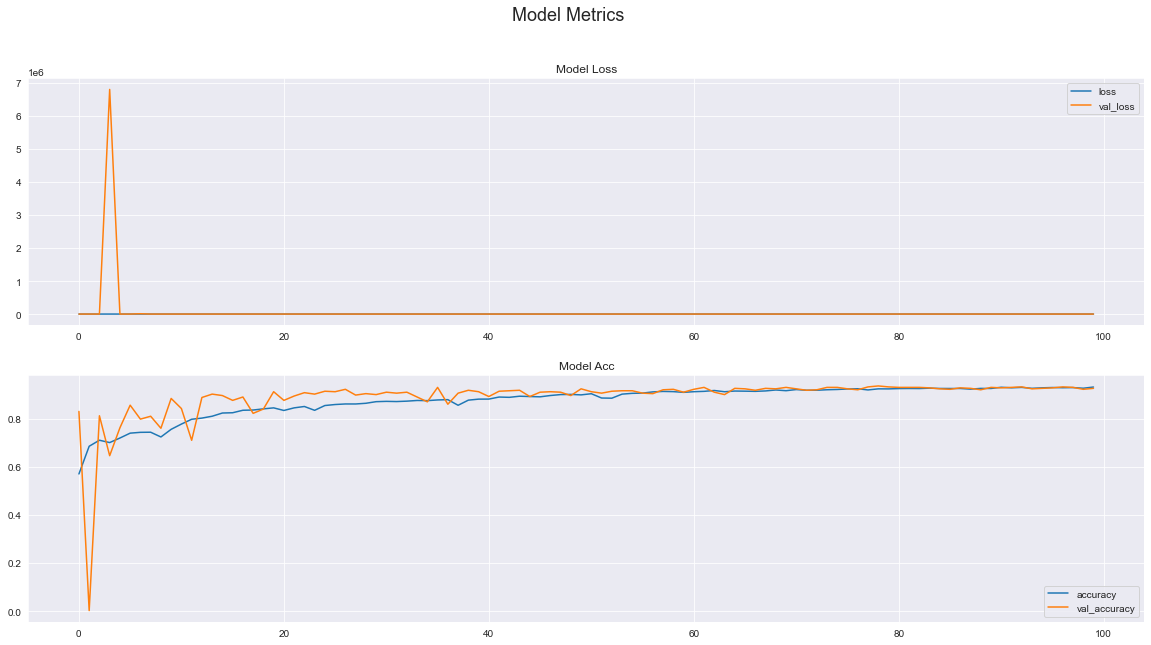

In [48]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_resnet_aug_D2.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

### Efficientnet with Augmented data 

In [49]:
#Build Effnet model
model_effnetB7_aug_D1 = Sequential() 
pretrained_model = EfficientNetB7(input_shape= (96, 96, 3), include_top= False, weights='imagenet')
pretrained_model.trainable = True

#Build Model Architecture
model_effnetB7_aug_D1.add(Conv2D(3, kernel_size=(2, 2), activation='relu', padding= 'same' ,input_shape=(96, 96, 1)))
model_effnetB7_aug_D1.add(LeakyReLU(alpha=0.1))
model_effnetB7_aug_D1.add(pretrained_model)
model_effnetB7_aug_D1.add(MaxPooling2D(pool_size=(2, 2)))
model_effnetB7_aug_D1.add(Dropout(0.1))
model_effnetB7_aug_D1.add(Flatten())
model_effnetB7_aug_D1.add(Dense(30))


model_effnetB7_aug_D1.summary()

model_effnetB7_aug_D1.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 3)         15        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 1, 1, 2560)        0         
                                                                 
 flatten_8 (Flatten)         (None, 2560)              0         
                                                      

In [50]:
#Train Model
start_time_effnetB7_aug_D1 = time.time()
history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=80, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetB7_aug_D1 = time.time() - start_time_effnetB7_aug_D1


#Evaluate Model
score_effnetB7_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_effnetB7_aug_D1[0])
print('Test accuracy:', score_effnetB7_aug_D1[1])

Epoch 1/80
255/255 [==============================] - 395s 1s/step - loss: 53.0159 - accuracy: 0.6561 - val_loss: 160.9317 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/80
255/255 [==============================] - 275s 1s/step - loss: 6.3416 - accuracy: 0.7331 - val_loss: 15.5447 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 3/80
255/255 [==============================] - 272s 1s/step - loss: 5.2555 - accuracy: 0.7728 - val_loss: 8.1877 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 4/80
255/255 [==============================] - 270s 1s/step - loss: 4.0410 - accuracy: 0.7969 - val_loss: 6.1314 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 5/80
255/255 [==============================] - 271s 1s/step - loss: 3.4590 - accuracy: 0.8157 - val_loss: 1.9826 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 6/80
255/255 [==============================] - 271s 1s/step - loss: 2.9052 - accuracy: 0.8239 - val_loss: 3.0111 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 7/80
255/255 [==============================] - 270s 1

In [ ]:
train_times = pd.DataFrame({
    "Baseline w/ Missing Values": 0.0,
    "Baseline w/o Missing Values": .8299,
    "CNN w/ FFill": .166,
    "CNN w/o Missing Values": .8280,
    "Resnet50 Pre-trained w/ 1 Dense Layer": .002,
    "Resnet Pre-trained w/ 2 Dense Layers": .90,
    "Resnet Pre-trained w/ Many Dense Layers": .8720,
    "EfficientNet w/ 1 Dense Layer": .912,
    "EfficientNetv2B3 w/ 2 Conv, 2 Dense layers": .8700,
    "Resnet50 w/ Augmented Data": .9260,
    "EfficientNet w/ Augmented Data": .9480,
    "EfficientNet w/ Augmented Data (Finetuned)": .9500
}, index = [0]).T.rename(columns = {0: "Time"})

In [51]:
#finetune
pretrained_model.trainable = True
model_effnetB7_aug_D1.summary()

model_effnetB7_aug_D1.compile(
    optimizer=Adam(1e-5),
    loss='mean_squared_error',
    metrics=['accuracy']
)

start2_time_effnetB7_aug_D1 = time.time()
history_effnetB7_aug_D1 = model_effnetB7_aug_D1.fit(train_data_aug, train_labels_aug, batch_size=64, epochs=20, validation_data=(dev_data, dev_labels), shuffle = True, callbacks=[earlyStopping, rlp])
train_time_effnetB7_aug_D1 = (time.time() - start2_time_effnetB7_aug_D1) + train_time_effnetB7_aug_D1

#pickle
pickle_stuff(model_effnetB7_aug_D1, train_time_effnetB7_aug_D1, history_effnetB7_aug_D1, 'model_effnetB7_aug_D1')

# #unpickle
# model_effnetB7_aug_D1, train_time_effnetB7_aug_D1, history_effnetB7_aug_D1 = unpickle_stuff('model_effnetB7_aug_D1')

#Evaulate Model
score_resnet_aug_D1 = model_effnetB7_aug_D1.evaluate(dev_data, dev_labels)
print('Test score:', score_resnet_aug_D1[0]) 
print('Test accuracy:', score_resnet_aug_D1[1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 3)         15        
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 1, 1, 2560)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 1, 1, 2560)        0         
                                                                 
 flatten_8 (Flatten)         (None, 2560)              0         
                                                      

Text(0.5, 0.98, 'Model Metrics')

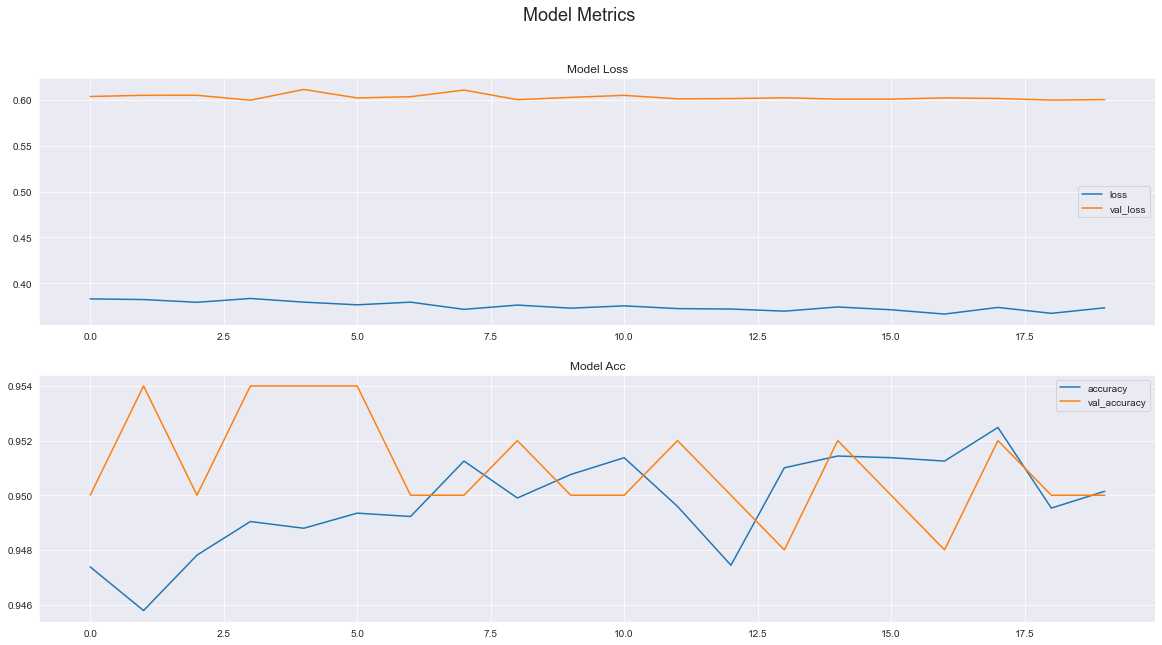

In [52]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
df = pd.DataFrame(history_effnetB7_aug_D1.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

## Creating Submission

In [ ]:
id_lookup = pd.read_csv('IdLookupTable.csv')

ImageId = list(id_lookup['ImageId']-1)
RowId = list(id_lookup['RowId'])
FeatureName = list(id_lookup['FeatureName'])
feature_list = []
for feature in FeatureName:
    feature_list.append(FeatureName.index(feature))



In [ ]:
def submit(model, test_data, model_name):
    #RowId,ImageId,FeatureName,Location
    #Make Predictions 
    y_pred = model.predict(test_data)

    predictions = []
    for x,y in zip(ImageId, feature_list):
        predictions.append(y_pred[x][y])
        
    row_ids = pd.Series(RowId, name = 'RowId')
    locations = pd.Series(predictions, name = 'Location')
    
    #post processing step 
    locations = locations.clip(0.0,96.0)
    submission_result = pd.concat([row_ids,locations],axis = 1)
    submission_result.to_csv('eff_net_2', index = False)


# Summary Charts

In [36]:
scores = pd.DataFrame({
    "Baseline w/ Missing Values": 0.0,
    "Baseline w/o Missing Values": .8299,
    "CNN w/ FFill": .166,
    "CNN w/o Missing Values": .8280,
    "Resnet50 Pre-trained w/ 1 Dense Layer": .89,
    "Resnet Pre-trained w/ 2 Dense Layers": .90,
    "Resnet Pre-trained w/ Many Dense Layers": .8720,
    "EfficientNet w/ 1 Dense Layer": .912,
    "EfficientNetv2B3 w/ 2 Conv, 2 Dense layers": .8700,
    "Resnet50 w/ Augmented Data": .9260,
    "EfficientNet w/ Augmented Data": .9480,
    "EfficientNet w/ Augmented Data (Finetuned)": .9500
}, index = [0]).T.rename(columns = {0: "Score"})

<ipython-input-37-dc8ee475576a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(scores.index, rotation = 30, ha="right", fontsize = 15)
<ipython-input-37-dc8ee475576a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, "0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 15)


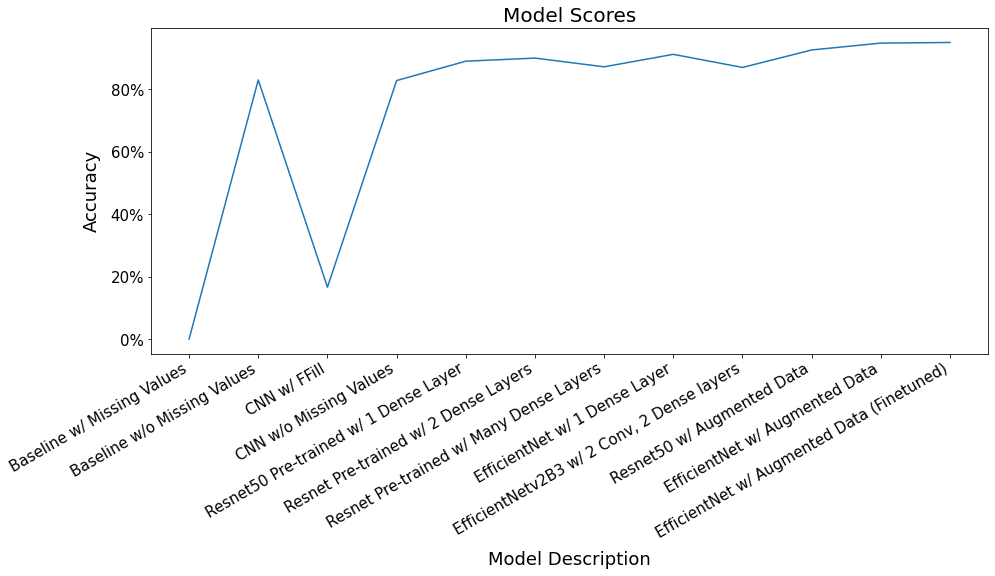

In [37]:
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = scores.index, y = scores['Score'], ax = ax)
ax.set_title("Model Scores", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 18, labelpad = 10)
ax.set_xlabel("Model Description", fontsize = 18, labelpad = 10)
ax.set_xticklabels(scores.index, rotation = 30, ha="right", fontsize = 15)
ax.set_yticklabels([0, "0%", "20%", "40%", "60%", "80%", "100%"], fontsize = 15)
fig.savefig("model_scores.jpg", bbox_inches = "tight", transparent = False)
plt.show()